# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from IPython.core.display import Image, display

# Custom Libraries
from density_forest.density_forest import *
from density_forest.density_tree_create import *
from density_forest.density_tree_traverse import *
from density_forest.create_data import *
from density_forest.helpers import *
from density_forest.plots import *

Using TensorFlow backend.


# Generate Data

First, let's generate some unlabelled data:


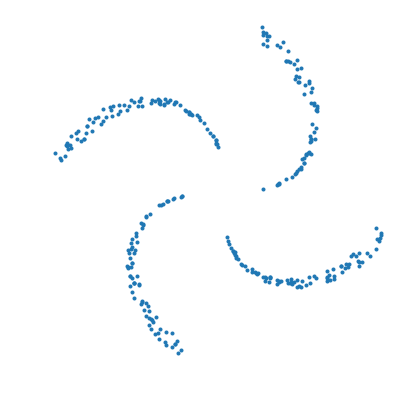

In [2]:
# dataset
d_id = 2
dimensions = 2


# Dataset 1: Random Points
if d_id == 1:
    nclusters = 4
    covariance = 5
    npoints = 1200
    margin = 20  # for plots
    minRange = 0
    maxRange = 100

    dataset = create_data(nclusters, dimensions, covariance, npoints, 
                          minrange=minRange, maxrange=maxRange,
                          labelled=False, random_flip=True, 
                          nonlinearities=True)

    if dimensions == 2:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(8,6)
        plot_data(draw_subsamples(dataset, .1), ax, labels=False, minrange=minRange, maxrange=maxRange, margin=30)
        plt.axis('off')
        plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)

        plt.show()

# Dataset 2: Fermat Spiral        
elif d_id==2:
    margin = 0  # for plots
    dataset, minRange, maxRange = create_spirals(n_points_arm=1000,
                                                 radius_min=np.pi / 50,
                                                 radius_max=7 * np.pi / 16,
                                                 divergence=0.05,
                                                 n_arms=4)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    subset = draw_subsamples(dataset, .02)
    ax.scatter(subset[...,0],subset[...,1], marker='.')
    plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)
    
    
# Dataset 3: S-shape
elif d_id==3:
    margin = 0  # for plots
    dataset, minRange, maxRange = create_S_shape(n_points_arm=3000, 
                                                 radius_min=np.pi / 4, 
                                                 radius_max=6 * np.pi / 4, 
                                                 divergence=0.05)


    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    subset = draw_subsamples(dataset, 1)
    ax.scatter(subset[...,0],subset[...,1], marker='.')
    plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)

#### Create single Density Tree

Dataset size: 16000
Minimum number of points in each leaf: 16


/raid/home/cwendl/SIE-Master/Code/density_forest/plots.py:238: RuntimeWarning: invalid value encountered in sqrt
  w, h = 2 * nstd * np.sqrt(vals)


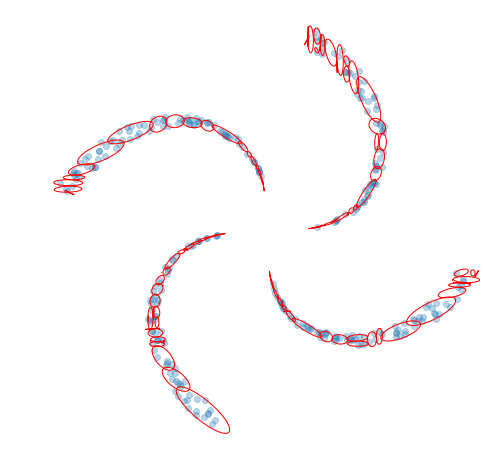

In [3]:
max_depth = 8
fact_improvement = .7
min_subset = 0.001
n_dim_max = 0

print("Dataset size: %i" % int(len(dataset)))
print("Minimum number of points in each leaf: %i" % int(len(dataset) * min_subset))

root = create_density_tree(dataset, max_depth=max_depth, min_subset=min_subset, n_max_dim=n_dim_max, 
                           verbose=True, ig_improvement=fact_improvement)

covs, means = get_clusters(root, [], [])    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
plt.scatter(subset[:,0], subset[:,1], alpha=.3)
plot_ellipses(ax, means, covs)
ax.set_title("")
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data-covs.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [4]:
def get_covs_means_depth(node, depth, means, covs, igs):
    """get covs and means of a tree at a certain depth"""
    
    if node.get_depth() == depth:
        means.append(node.mean)
        covs.append(node.cov)
        igs.append(node.parent.ig)
        
    if node.get_depth() < depth and node.right is None:
        means.append(node.right_mean)
        covs.append(node.right_cov)
        igs.append(node.parent.ig)

    if node.get_depth() < depth and node.left is None:
        means.append(node.left_mean)
        covs.append(node.left_cov)
        igs.append(node.parent.ig)
        
    if node.left is not None:
        means, covs, igs =  get_covs_means_depth(node.left, depth, means, covs, igs)

    if node.right is not None:
        means, covs, igs = get_covs_means_depth(node.right, depth, means, covs, igs)
    
    return means, covs, igs

In [5]:
def plot_ellipses(ax, means=None, covs=None, igs=None):
    """
    Overlay covariance ellipses on a 2D plot
    """
    #  covariance
    def eigsorted(cov):
        vals_, vecs_ = np.linalg.eigh(cov)
        order = vals_.argsort()[::-1]
        return vals_[order], vecs_[:, order]

    nstd = 2
    for i in range(len(covs)):
        vals, vecs = eigsorted(covs[i])
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        w, h = 2 * nstd * np.sqrt(vals)
        ell = Ellipse(xy=means[i],
                      width=w, height=h,
                      angle=theta, color='red')
        ell.set_facecolor('none')
        ax.add_artist(ell)
        if igs is not None:
            ax.text(means[i][0], means[i][1], np.round(igs[i], 2),color='red')


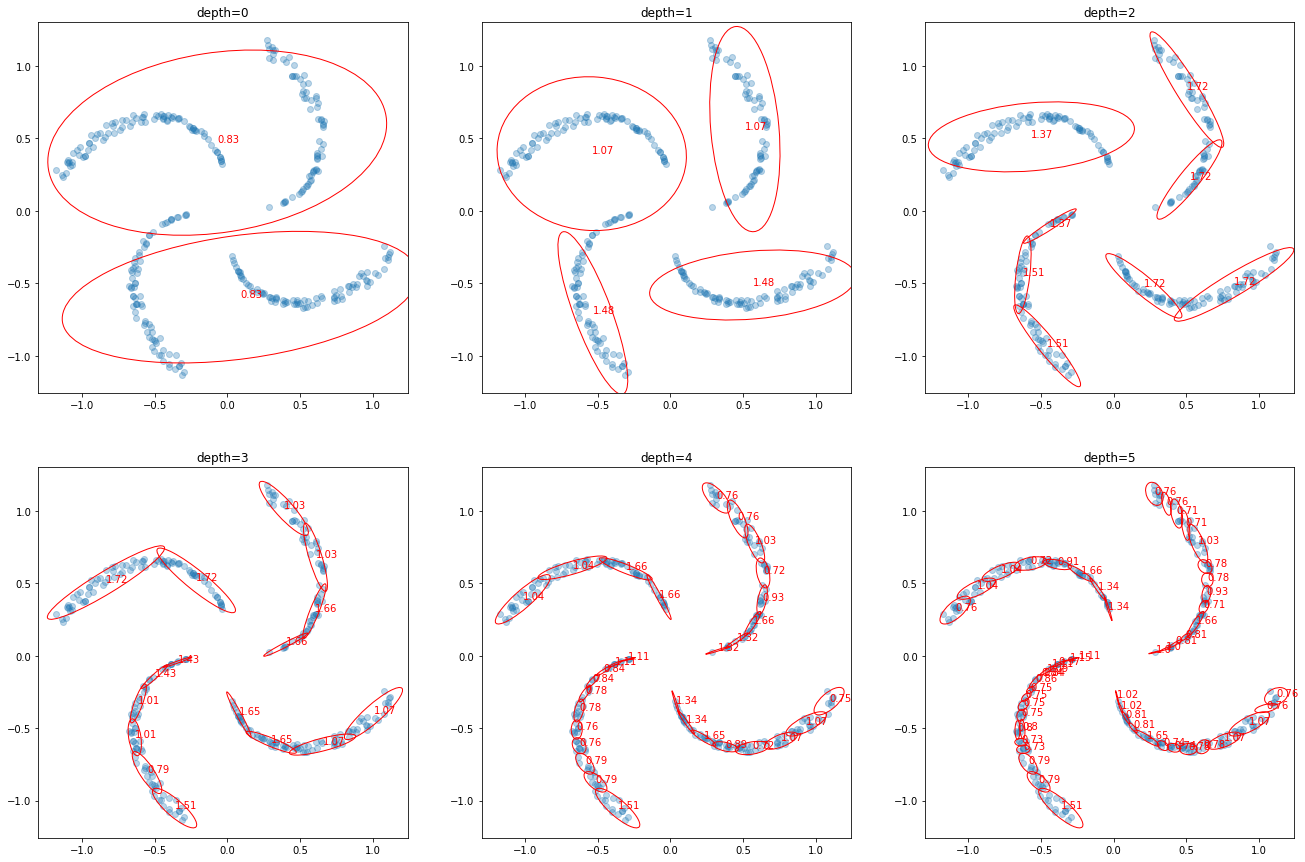

In [6]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(22.5,15)

for i in range(3):
    means, covs, igs = get_covs_means_depth(root,i+1,[], [], [])
    axes[0][i].scatter(subset[:,0],subset[:,1], alpha=.3)
    plot_ellipses(axes[0][i], means, covs, igs)
    axes[0][i].set_title('depth=%i'%i)
    
for i in range(3,6):
    means, covs, igs = get_covs_means_depth(root,i+1,[], [], [])
    axes[1][i-3].scatter(subset[:,0],subset[:,1], alpha=.3)
    plot_ellipses(axes[1][i-3], means, covs, igs)
    axes[1][i-3].set_title('depth=%i'%i)
    
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data_covs_steps.pdf", bbox_inches='tight', pad_inches=0)

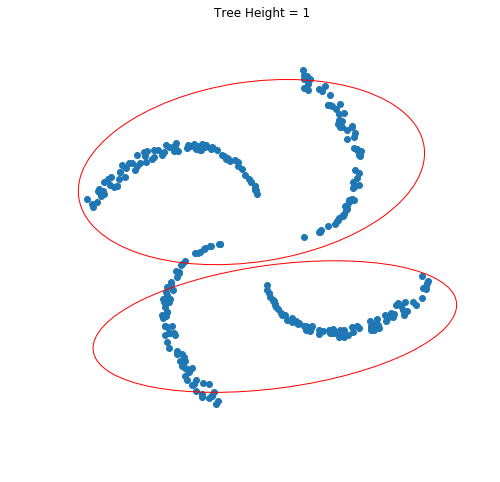

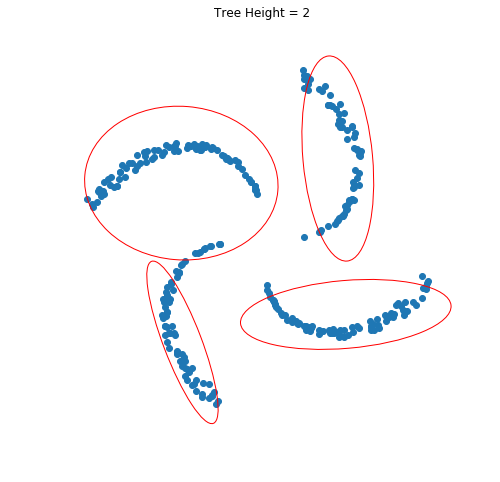

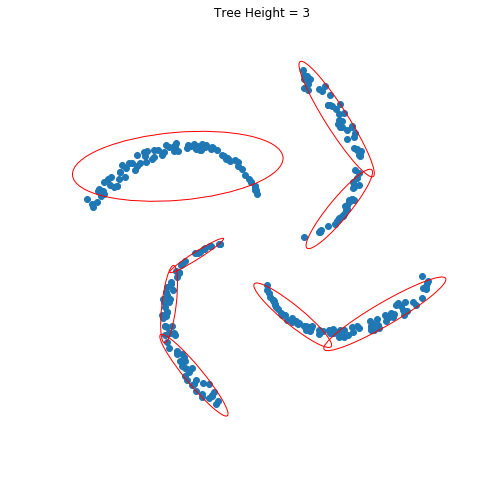

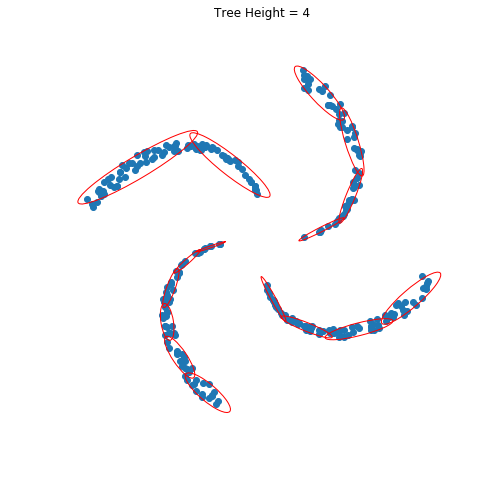

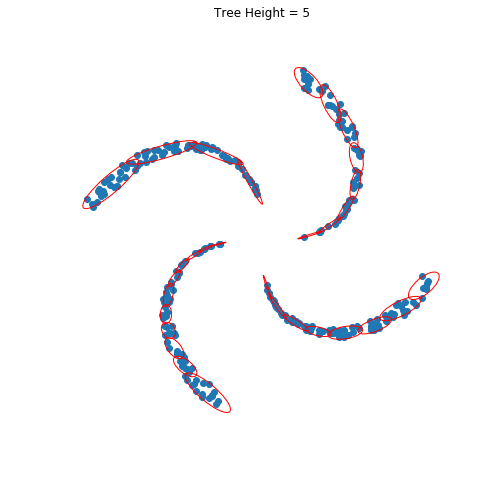

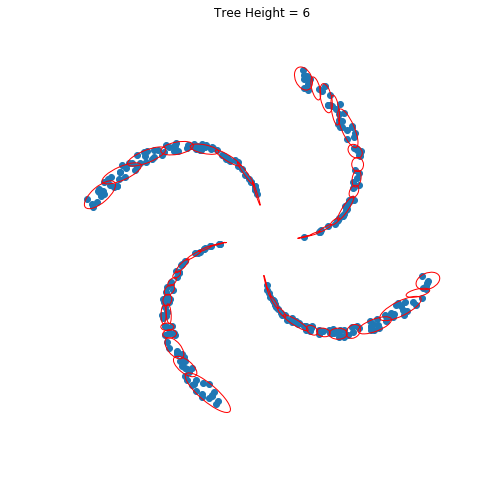

In [7]:
for i in range(1,7):
    means, covs, igs = get_covs_means_depth(root,i,[],[],[])
    fig, axes = plt.subplots(1, 1, figsize=(8,8))
    plt.scatter(subset[:,0],subset[:,1])
    plot_ellipses(axes, means, covs)
    plt.axis('off')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.title("Tree Height = "+str(i))
    plt.savefig("../Figures/density_tree/gif/D" + str(d_id) + "_data_h_"+str(i)+".pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

# Printing the Tree

In [8]:
# ATTENTION: requires LaTeX, imagemagick to be installed

def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    cdir = "cd ../Figures/density_tree;"
    
    os.system(cdir + "rm density-tree.tex")
    os.system(cdir + "more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system(cdir + "echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system(cdir + "/Library/TeX/texbin/pdflatex density-tree.tex")
    os.system(cdir + "convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system(cdir + "rm *.aux *.log")
    #display(Image('../Figures/density_tree/density-tree.png', retina=True))
    
tree_visualize(root)

In [9]:
from scipy.stats import multivariate_normal

# loop
def create_plot_surface(minRange, maxRange, roots, n_points_dim=100, standardize=False, thresh=.01):
    """thresh: pct of data in each leaf node"""
    grid = np.linspace(minRange, maxRange, n_points_dim)
    probas_out = np.zeros((n_points_dim,n_points_dim))

    
    for idx_x, pt in tqdm(enumerate(grid)):
        for idx_y, g in enumerate(grid):
            proba_pt=[]
            for root in roots:
                # descend tree
                d_mean, d_pct, d_pdf_mean, d_cov_det, d_cov_inv = descend_density_tree([pt, g], root)
                # probability for this point to be from this distribution
                if d_pct>thresh:
                    try:
                        mn = my_normal(np.asarray([pt, g]), d_mean, d_cov_det, d_cov_inv)
                        if standardize: 
                            mn /= d_pdf_mean
                        proba_pt.append(mn)
                    except:
                        proba_pt.append(np.nan)

                
            probas_out[idx_x, idx_y] = np.nanmean(proba_pt)

    return probas_out

In [10]:
probas = create_plot_surface(minRange-margin, maxRange+margin, [root], n_points_dim=150, standardize=False, thresh=0)
probas = np.flipud(probas.T)

150it [00:01, 115.21it/s]


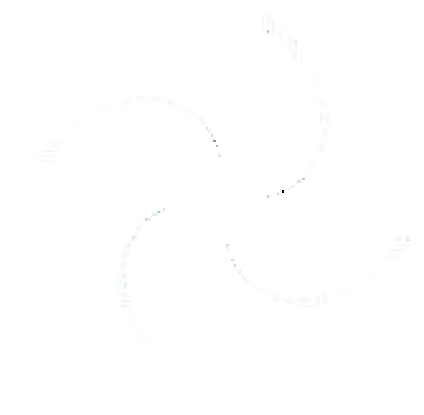

In [11]:
fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='bone')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_one_tree.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

#### Density Forest

In [13]:
clf_df = DensityForest(max_depth=5, min_subset=.1, n_trees=20,
                       n_max_dim=-1, n_jobs=-1, ig_improvement=.8, subsample_pct=.02)

In [14]:
clf_df.fit(dataset)

Number of points on which to train each tree: 320
Minimum number of points in each leaf: 32


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:    1.9s remaining:    7.8s


Number of created root nodes: 20
Mean number of clusters created per tree: 16


[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:    3.8s finished


150it [00:16,  9.01it/s]


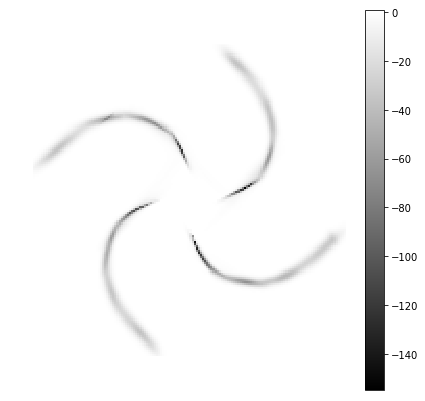

In [15]:
probas = create_plot_surface(minRange-margin, maxRange+margin, clf_df.root_nodes, n_points_dim=150, standardize=False, thresh=0)
probas = np.flipud(probas.T)

fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='gray')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_DF_forest.pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()

150it [00:14, 10.17it/s]


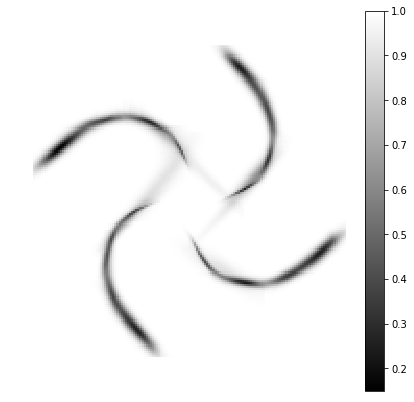

In [16]:
# standardized version
probas = create_plot_surface(minRange-margin, maxRange+margin, clf_df.root_nodes, n_points_dim=150, standardize=True, thresh=.001)
probas = np.flipud(probas.T)

fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='gray')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_DF_stand.pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()